# Evaluación Parcial 2 - Fundamentos de Deep Learning
### Dataset: simpsons_dataset - Clasificación de personajes de Los Simpsons con CNN

Este proyecto utiliza una red neuronal convolucional (CNN) para identificar automáticamente personajes de la serie *Los Simpsons* en imágenes. Usaremos un dataset con 18 personajes y aplicaremos técnicas de Deep Learning con TensorFlow/Keras.

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, MaxPooling2D
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
import glob

%matplotlib inline


In [ ]:
# Crear directorio base
!mkdir -p /content/simpsons

# Descargar dataset de entrenamiento (~500MB)
!gdown 1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La -O /content/archive.zip

# Descomprimir el ZIP
!unzip -q /content/archive.zip -d /content/simpsons

# Verificar estructura
print("Estructura de carpetas extraídas:")
!ls -la /content/simpsons


Downloading...
From (original): https://drive.google.com/uc?id=1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La
From (redirected): https://drive.google.com/uc?id=1DeToSr-V_BJn3FTRD40J2HvlB8BNP_La&confirm=t&uuid=280f82c3-3882-4cb0-85e3-c2cf8dceabe3
To: /content/archive.zip
100% 1.16G/1.16G [00:14<00:00, 79.5MB/s]
Estructura de carpetas extraídas:
total 81304
drwxr-xr-x  4 root root     4096 May 20 20:52 .
drwxr-xr-x  1 root root     4096 May 20 20:52 ..
-rw-r--r--  1 root root   491788 Sep 20  2019 annotation.txt
-rw-r--r--  1 root root   598494 Sep 20  2019 characters_illustration.png
drwxr-xr-x  3 root root     4096 May 20 20:52 kaggle_simpson_testset
-rw-r--r--  1 root root     1452 Sep 20  2019 number_pic_char.csv
drwxr-xr-x 45 root root     4096 May 20 20:52 simpsons_dataset
-rw-r--r--  1 root root 82136544 Sep 20  2019 weights.best.hdf5


In [ ]:
DATASET_TRAIN_PATH = "/content/simpsons/simpsons_dataset"
DATASET_TEST_PATH = "/content/simpsons/kaggle_simpson_testset"

# Verificar existencia
print(f"Carpeta de entrenamiento existe: {os.path.exists(DATASET_TRAIN_PATH)}")
print(f"Carpeta de prueba existe: {os.path.exists(DATASET_TEST_PATH)}")


Carpeta de entrenamiento existe: True
Carpeta de prueba existe: True


Listar personajes y contar imagenes por clase

In [ ]:
# Mostrar cuántos personajes hay y cuántas imágenes tiene cada uno
if os.path.exists(DATASET_TRAIN_PATH):
    personajes = [d for d in os.listdir(DATASET_TRAIN_PATH) if os.path.isdir(os.path.join(DATASET_TRAIN_PATH, d))]
    print(f"Número de personajes en el dataset de entrenamiento: {len(personajes)}")
    print(f"Ejemplos de personajes: {personajes[:5]}")  # muestra los primeros 5

    total_imagenes = 0
    conteo_personajes = {}

    for personaje in personajes:
        ruta_personaje = os.path.join(DATASET_TRAIN_PATH, personaje)
        cantidad = len([f for f in os.listdir(ruta_personaje) if f.lower().endswith(('.jpg', '.png'))])
        conteo_personajes[personaje] = cantidad
        total_imagenes += cantidad

    print(f"\nTotal de imágenes de entrenamiento: {total_imagenes}")
    print("\nPersonajes con más imágenes:")
    for personaje, cantidad in sorted(conteo_personajes.items(), key=lambda x: x[1], reverse=True):
        print(f"{personaje}: {cantidad} imágenes")
else:
    print("La carpeta de entrenamiento no existe o está vacía.")


Número de personajes en el dataset de entrenamiento: 43
Ejemplos de personajes: ['ned_flanders', 'lionel_hutz', 'lisa_simpson', 'homer_simpson', 'barney_gumble']

Total de imágenes de entrenamiento: 20933

Personajes con más imágenes:
homer_simpson: 2246 imágenes
ned_flanders: 1454 imágenes
moe_szyslak: 1452 imágenes
lisa_simpson: 1354 imágenes
bart_simpson: 1342 imágenes
marge_simpson: 1291 imágenes
krusty_the_clown: 1206 imágenes
principal_skinner: 1194 imágenes
charles_montgomery_burns: 1193 imágenes
milhouse_van_houten: 1079 imágenes
chief_wiggum: 986 imágenes
abraham_grampa_simpson: 913 imágenes
sideshow_bob: 877 imágenes
apu_nahasapeemapetilon: 623 imágenes
kent_brockman: 498 imágenes
comic_book_guy: 469 imágenes
edna_krabappel: 457 imágenes
nelson_muntz: 358 imágenes
lenny_leonard: 310 imágenes
mayor_quimby: 246 imágenes
waylon_smithers: 181 imágenes
maggie_simpson: 128 imágenes
groundskeeper_willie: 121 imágenes
barney_gumble: 106 imágenes
selma_bouvier: 103 imágenes
carl_carls

Cargar solo los 18 personajes principales

In [ ]:
# Definir los 18 personajes con más imágenes
TOP_18_PERSONAJES = [
    'homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson',
    'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns',
    'milhouse_van_houten', 'chief_wiggum', 'abraham_grampa_simpson', 'sideshow_bob',
    'apu_nahasapeemapetilon', 'kent_brockman', 'comic_book_guy', 'edna_krabappel', 'nelson_muntz'
]

# Mapeo de etiqueta numérica a personaje
MAP_CHARACTERS = {i: personaje for i, personaje in enumerate(TOP_18_PERSONAJES)}

# Función para cargar las imágenes
def load_images(path, map_characters, img_size=64):
    X = []
    y = []
    for label, personaje in map_characters.items():
        carpeta = os.path.join(path, personaje)
        archivos = [f for f in os.listdir(carpeta) if f.endswith(".jpg")]
        print(f"Leyendo {len(archivos)} imágenes de {personaje}")
        for archivo in archivos:
            img_path = os.path.join(carpeta, archivo)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

# Cargar los datos
X, y = load_images(DATASET_TRAIN_PATH, MAP_CHARACTERS)


Leyendo 2246 imágenes de homer_simpson
Leyendo 1454 imágenes de ned_flanders
Leyendo 1452 imágenes de moe_szyslak
Leyendo 1354 imágenes de lisa_simpson
Leyendo 1342 imágenes de bart_simpson
Leyendo 1291 imágenes de marge_simpson
Leyendo 1206 imágenes de krusty_the_clown
Leyendo 1194 imágenes de principal_skinner
Leyendo 1193 imágenes de charles_montgomery_burns
Leyendo 1079 imágenes de milhouse_van_houten
Leyendo 986 imágenes de chief_wiggum
Leyendo 913 imágenes de abraham_grampa_simpson
Leyendo 877 imágenes de sideshow_bob
Leyendo 623 imágenes de apu_nahasapeemapetilon
Leyendo 498 imágenes de kent_brockman
Leyendo 469 imágenes de comic_book_guy
Leyendo 457 imágenes de edna_krabappel
Leyendo 358 imágenes de nelson_muntz


- Normalizar los pixeles (dividir por 255)

- Convertir etiquetas (y) a one-hot encoding

- Separar en entrenamiento y validación (80/20)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Normalizar imágenes
X = X.astype('float32') / 255.0

# 2. Convertir etiquetas a one-hot (18 clases)
y_cat = to_categorical(y, num_classes=18)

# 3. Dividir en entrenamiento y validación (80/20)
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

# Mostrar formas
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


X_train: (15193, 64, 64, 3), y_train: (15193, 18)
X_val: (3799, 64, 64, 3), y_val: (3799, 18)


# Arquitectura modelo CNN simple

In [ ]:
# Modelo CNN simple
model = Sequential([
    # Capa 1: Conv + MaxPooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Capa 2: Conv + MaxPooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Aplanar la salida
    Flatten(),

    # Capa densa oculta
    Dense(128, activation='relu'),

    # Capa de salida (18 clases)
    Dense(18, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,474 (6.21 MB)

 Trainable params: 1,627,474 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

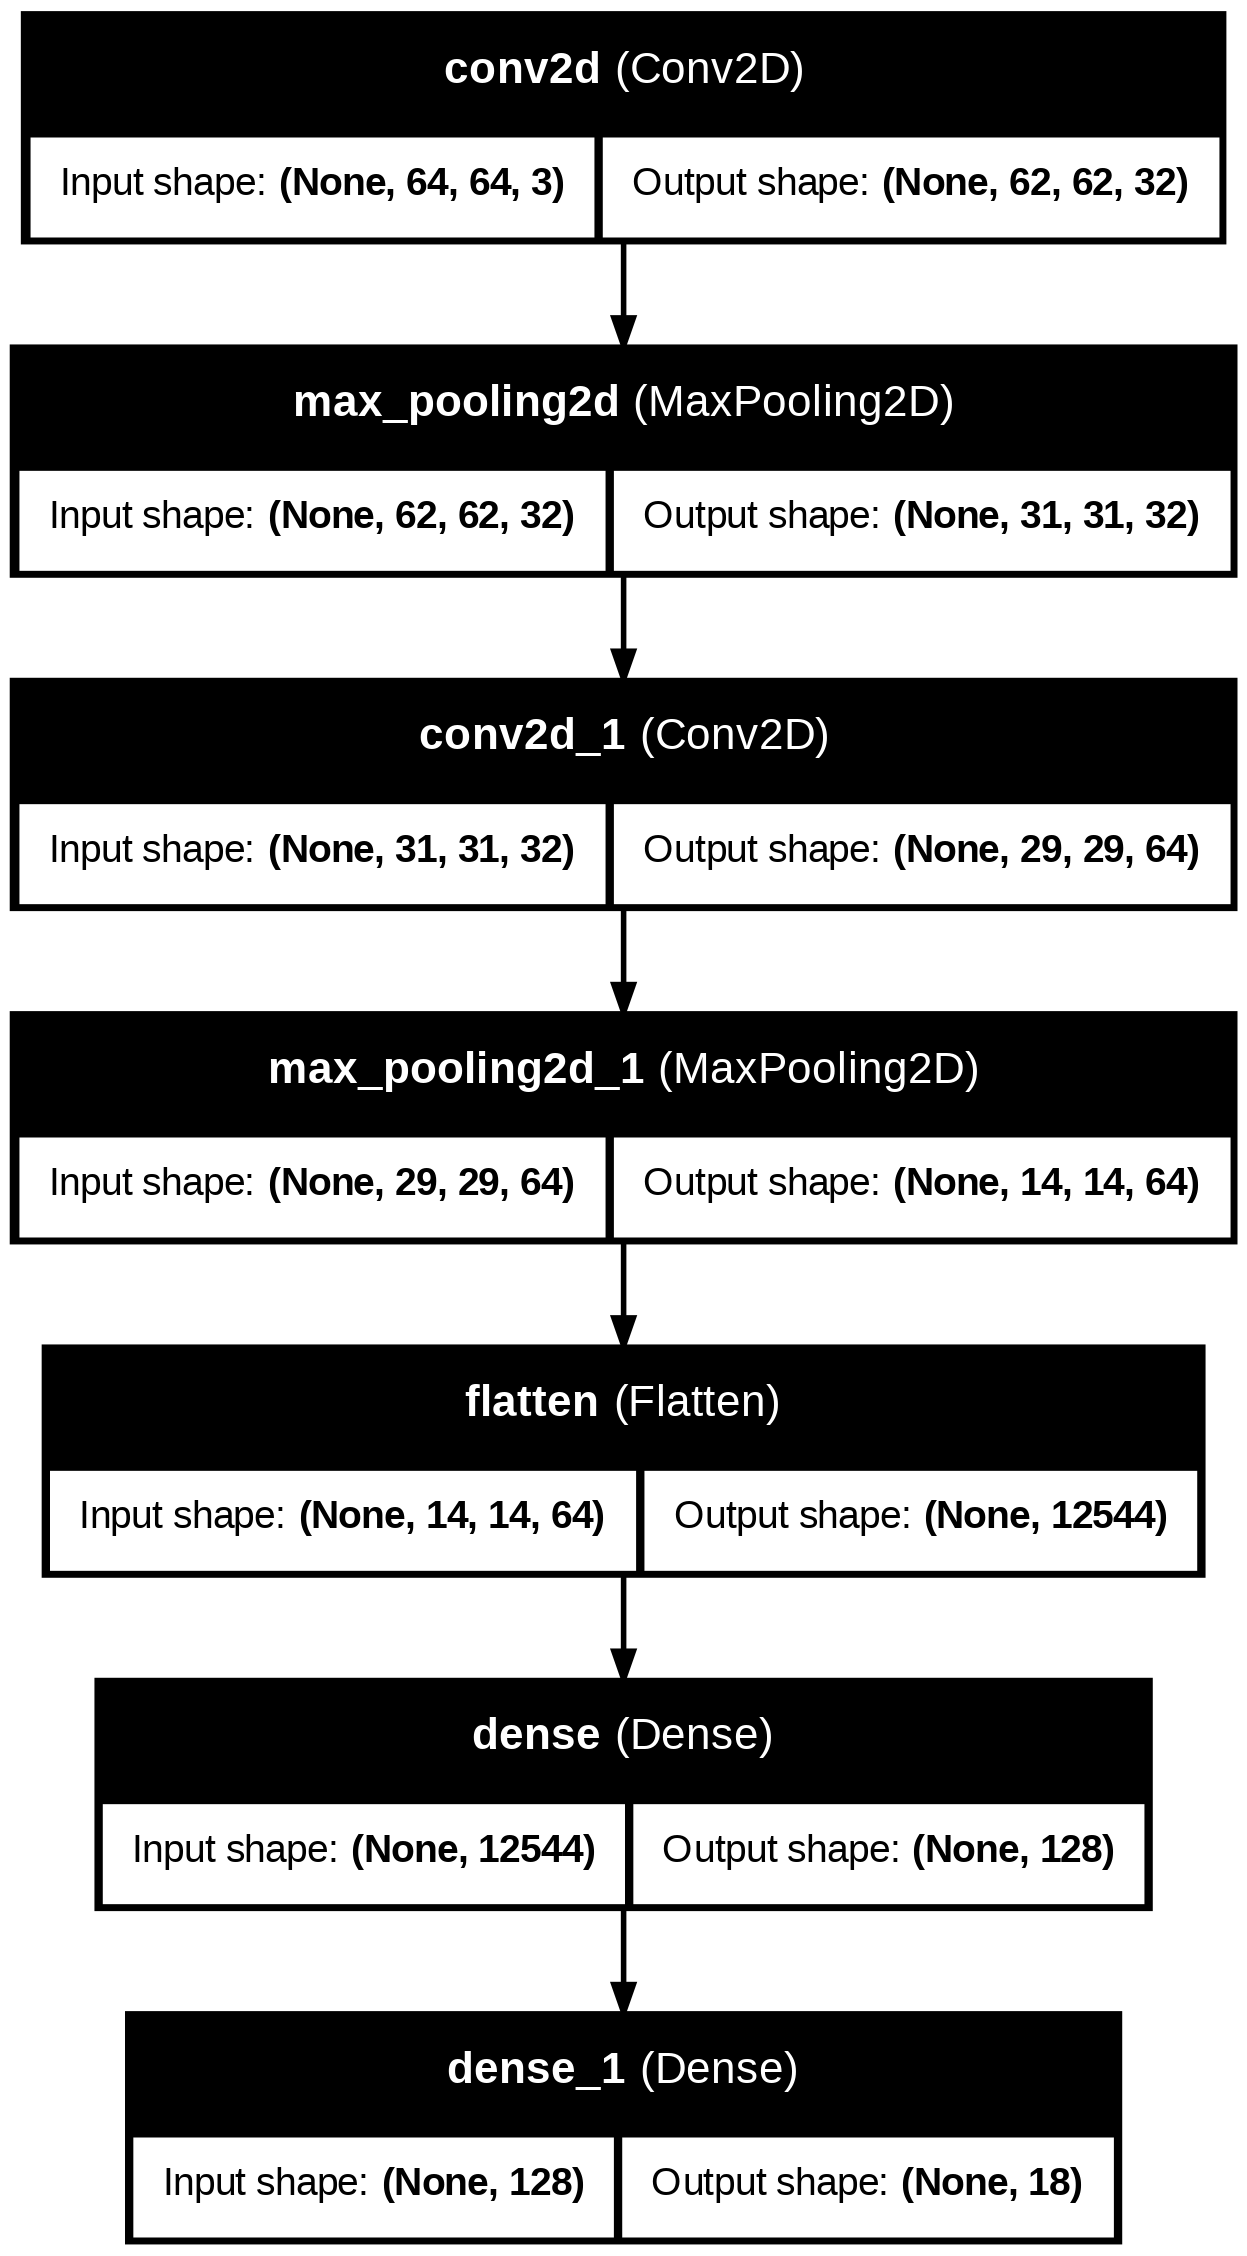

In [ ]:
!apt-get -qq install graphviz
!pip install -q pydot
from tensorflow.keras.utils import plot_model

# Guardar el gráfico como imagen PNG
plot_model(model, to_file='modelo_cnn.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename='modelo_cnn.png')


## Entrenamiento del modelo

In [ ]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=20,               # Puedes probar con 15-20 más adelante
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 109s 220ms/step - accuracy: 0.3363 - loss: 2.1910 - val_accuracy: 0.6099 - val_loss: 1.3609
Epoch 2/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 126s 188ms/step - accuracy: 0.6747 - loss: 1.0898 - val_accuracy: 0.6904 - val_loss: 1.0724
Epoch 3/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 143s 191ms/step - accuracy: 0.8226 - loss: 0.6168 - val_accuracy: 0.7470 - val_loss: 0.9016
Epoch 4/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 99s 209ms/step - accuracy: 0.9038 - loss: 0.3330 - val_accuracy: 0.7531 - val_loss: 0.9253
Epoch 5/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 139s 203ms/step - accuracy: 0.9529 - loss: 0.1651 - val_accuracy: 0.7805 - val_loss: 0.9616
Epoch 6/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 143s 205ms/step - accuracy: 0.9823 - loss: 0.0767 - val_accuracy: 0.7707 - val_loss: 1.0956
Epoch 7/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 137s 195ms/step - accuracy: 0.9899 - loss: 0.0479 - val_accuracy: 0.7602 - val_loss: 1.2718
Epoch 8/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 145s 201ms/step - accuracy: 0.9845 - 

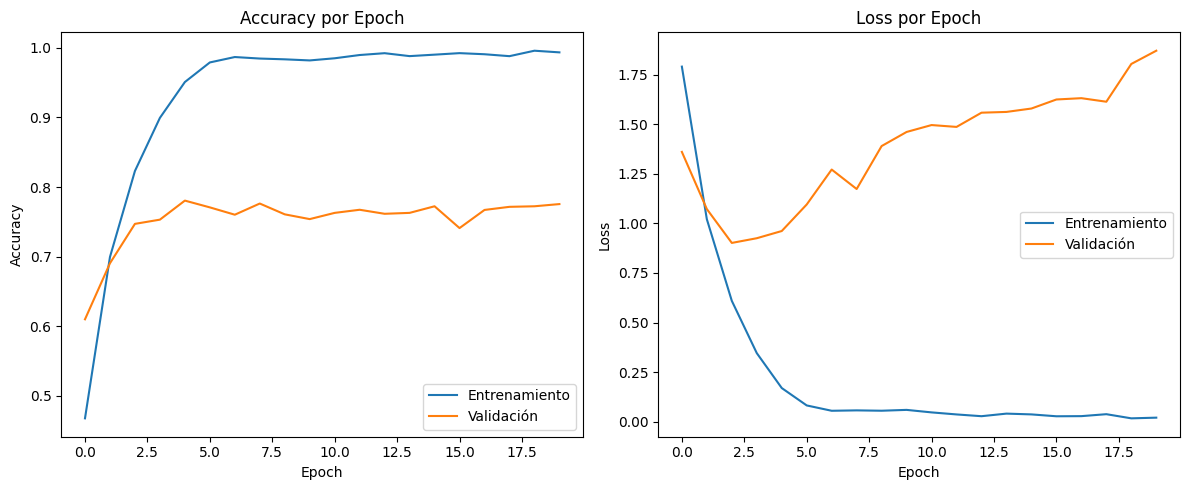

In [ ]:
# Gráfica de accuracy y pérdida
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Accuracy por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Loss por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Esto es una señal clara de overfitting: el modelo memoriza, pero no generaliza.
El loss de validación baja al inicio pero luego empieza a subir lo que puede ser un clásico sobreajuste.

In [ ]:
# Predecimos etiquetas (como vectores de probabilidades)
y_pred_prob = model.predict(X_val)

# Convertimos de one-hot a etiqueta (clase)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)


119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step


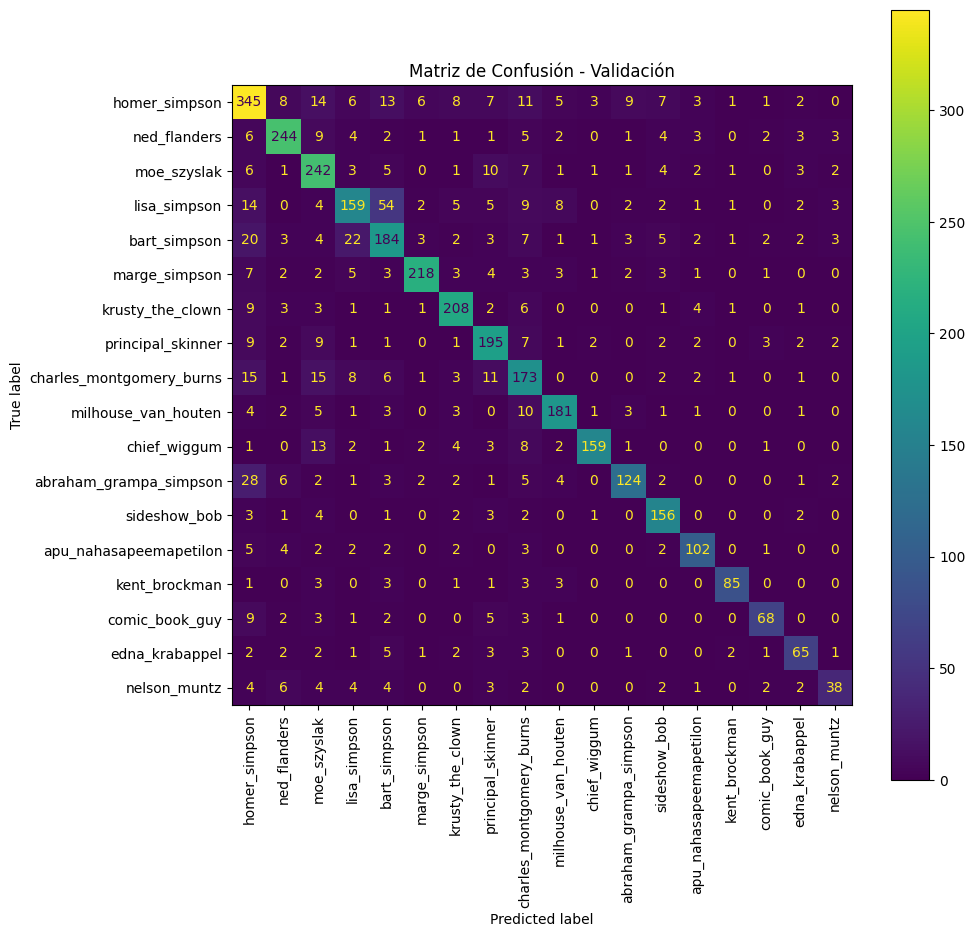

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Crear matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrarla de forma visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(MAP_CHARACTERS.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='viridis')
plt.title("Matriz de Confusión - Validación")
plt.show()


Ver errores de predicción

Número de errores: 853


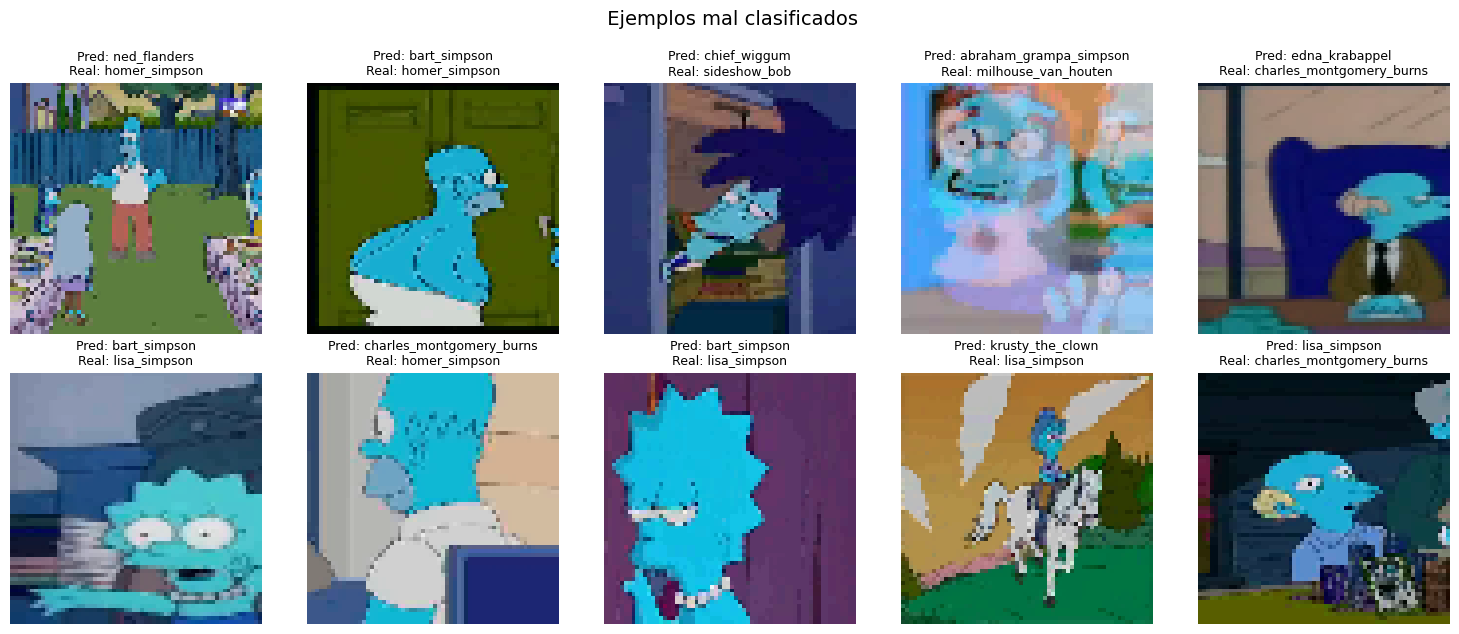

In [ ]:
# Encontrar los errores
errores = np.where(y_pred != y_true)[0]
print(f"Número de errores: {len(errores)}")

# Mostrar algunos
import random
random.seed(42)
ejemplos = random.sample(list(errores), 10)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(ejemplos):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_val[idx])
    predicho = MAP_CHARACTERS[y_pred[idx]]
    verdadero = MAP_CHARACTERS[y_true[idx]]
    plt.title(f"Pred: {predicho}\nReal: {verdadero}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.suptitle(" Ejemplos mal clasificados", fontsize=14, y=1.05)
plt.show()


## Mejorando el modelo

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generador con aumento de datos
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Ajustar al set de entrenamiento
datagen.fit(X_train)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callback para guardar solo el mejor modelo (según val_accuracy)
checkpoint = ModelCheckpoint(
    filepath='mejor_modelo_aug.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback para detener el entrenamiento si no mejora por 3 epochs
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento con callbacks + data augmentation
history_aug_v2 = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6326 - loss: 1.3940
Epoch 1: val_accuracy improved from -inf to 0.81100, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 114s 239ms/step - accuracy: 0.6327 - loss: 1.3934 - val_accuracy: 0.8110 - val_loss: 0.6802
Epoch 2/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7565 - loss: 0.8285
Epoch 2: val_accuracy improved from 0.81100 to 0.82601, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 111s 234ms/step - accuracy: 0.7565 - loss: 0.8285 - val_accuracy: 0.8260 - val_loss: 0.6257
Epoch 3/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7886 - loss: 0.7017
Epoch 3: val_accuracy did not improve from 0.82601
475/475 ━━━━━━━━━━━━━━━━━━━━ 112s 235ms/step - accuracy: 0.7886 - loss: 0.7017 - val_accuracy: 0.8092 - val_loss: 0.6720
Epoch 4/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8163 - loss: 0.6114
Epoch 4: val_accuracy improved from 0.82601 to 0.84075, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 113s 237ms/step - accuracy: 0.8163 - loss: 0.6114 - val_accuracy: 0.8407 - val_loss: 0.5637
Epoch 5/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8377 - loss: 0.5500
Epoch 5: val_accuracy did not improve from 0.84075
475/475 ━━━━━━━━━━━━━━━━━━━━ 114s 240ms/step - accuracy: 0.8377 - loss: 0.5500 - val_accuracy: 0.8384 - val_loss: 0.5671
Epoch 6/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8472 - loss: 0.4999
Epoch 6: val_accuracy improved from 0.84075 to 0.85154, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 113s 238ms/step - accuracy: 0.8471 - loss: 0.5000 - val_accuracy: 0.8515 - val_loss: 0.5196
Epoch 7/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8630 - loss: 0.4540
Epoch 7: val_accuracy improved from 0.85154 to 0.86523, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 111s 233ms/step - accuracy: 0.8629 - loss: 0.4541 - val_accuracy: 0.8652 - val_loss: 0.5039
Epoch 8/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8724 - loss: 0.4172
Epoch 8: val_accuracy improved from 0.86523 to 0.87102, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 111s 233ms/step - accuracy: 0.8724 - loss: 0.4172 - val_accuracy: 0.8710 - val_loss: 0.4744
Epoch 9/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8765 - loss: 0.3999
Epoch 9: val_accuracy did not improve from 0.87102
475/475 ━━━━━━━━━━━━━━━━━━━━ 111s 233ms/step - accuracy: 0.8765 - loss: 0.3999 - val_accuracy: 0.8684 - val_loss: 0.4789
Epoch 10/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8828 - loss: 0.3774
Epoch 10: val_accuracy did not improve from 0.87102
475/475 ━━━━━━━━━━━━━━━━━━━━ 111s 234ms/step - accuracy: 0.8828 - loss: 0.3774 - val_accuracy: 0.8708 - val_loss: 0.4888
Epoch 11/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8916 - loss: 0.3574
Epoch 11: val_accuracy improved from 0.87102 to 0.87260, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 144s 238ms/step - accuracy: 0.8916 - loss: 0.3574 - val_accuracy: 0.8726 - val_loss: 0.4823
Epoch 12/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8912 - loss: 0.3437
Epoch 12: val_accuracy improved from 0.87260 to 0.87918, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 140s 235ms/step - accuracy: 0.8912 - loss: 0.3437 - val_accuracy: 0.8792 - val_loss: 0.4520
Epoch 13/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9006 - loss: 0.3229
Epoch 13: val_accuracy did not improve from 0.87918
475/475 ━━━━━━━━━━━━━━━━━━━━ 116s 245ms/step - accuracy: 0.9006 - loss: 0.3229 - val_accuracy: 0.8773 - val_loss: 0.4526
Epoch 14/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9095 - loss: 0.2938
Epoch 14: val_accuracy improved from 0.87918 to 0.87971, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 112s 236ms/step - accuracy: 0.9095 - loss: 0.2939 - val_accuracy: 0.8797 - val_loss: 0.4780
Epoch 15/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9167 - loss: 0.2852
Epoch 15: val_accuracy did not improve from 0.87971
475/475 ━━━━━━━━━━━━━━━━━━━━ 111s 234ms/step - accuracy: 0.9167 - loss: 0.2852 - val_accuracy: 0.8544 - val_loss: 0.5592
Epoch 16/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9122 - loss: 0.2855
Epoch 16: val_accuracy improved from 0.87971 to 0.88339, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 144s 238ms/step - accuracy: 0.9122 - loss: 0.2855 - val_accuracy: 0.8834 - val_loss: 0.4682
Epoch 17/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9156 - loss: 0.2693
Epoch 17: val_accuracy did not improve from 0.88339
475/475 ━━━━━━━━━━━━━━━━━━━━ 141s 236ms/step - accuracy: 0.9156 - loss: 0.2693 - val_accuracy: 0.8750 - val_loss: 0.5349
Epoch 18/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9175 - loss: 0.2584
Epoch 18: val_accuracy did not improve from 0.88339
475/475 ━━━━━━━━━━━━━━━━━━━━ 113s 238ms/step - accuracy: 0.9175 - loss: 0.2584 - val_accuracy: 0.8794 - val_loss: 0.4714
Epoch 19/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9248 - loss: 0.2470
Epoch 19: val_accuracy improved from 0.88339 to 0.88813, saving model to mejor_modelo_aug.h5


475/475 ━━━━━━━━━━━━━━━━━━━━ 120s 252ms/step - accuracy: 0.9248 - loss: 0.2470 - val_accuracy: 0.8881 - val_loss: 0.4777
Epoch 20/20
475/475 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9294 - loss: 0.2368
Epoch 20: val_accuracy did not improve from 0.88813
475/475 ━━━━━━━━━━━━━━━━━━━━ 116s 245ms/step - accuracy: 0.9294 - loss: 0.2368 - val_accuracy: 0.8823 - val_loss: 0.4902
Restoring model weights from the end of the best epoch: 19.


## Cargar Mejor Modelo

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el mejor modelo entrenado
modelo_final = load_model('mejor_modelo_aug.h5')
print(" Modelo cargado correctamente.")


 Modelo cargado correctamente.


## Desempeño final del modelo optimizado

In [ ]:
loss, acc = modelo_final.evaluate(X_val, y_val)
print(f"Precisión final en validación: {acc:.4f} | Pérdida: {loss:.4f}")


119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8877 - loss: 0.4789
Precisión final en validación: 0.8881 | Pérdida: 0.4777


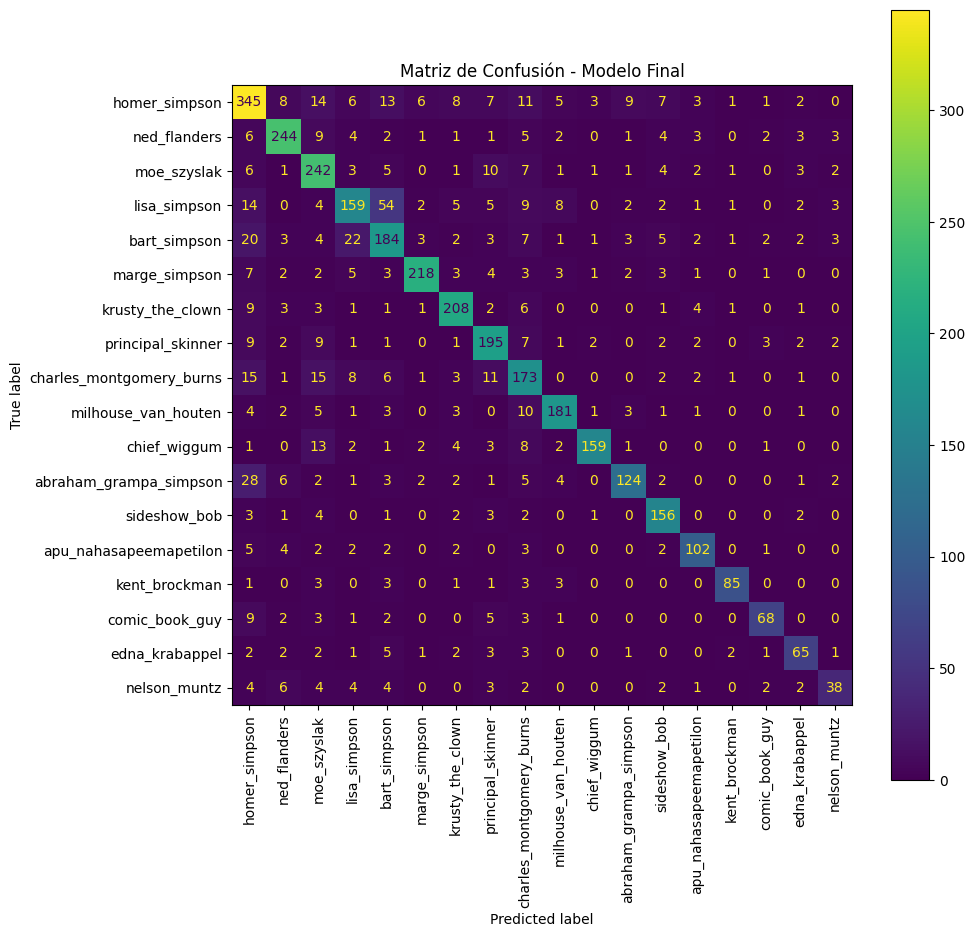

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(MAP_CHARACTERS.values()))
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='viridis')
plt.title("Matriz de Confusión - Modelo Final")
plt.show()


Tras aplicar técnicas de aumento de datos y usar callbacks como EarlyStopping y ModelCheckpoint, el modelo alcanzó una precisión en validación del 87.34% y mejoró significativamente en la identificación de personajes clave como homer_simpson, krusty_the_clown y milhouse_van_houten, como se evidencia en la matriz de confusión final.

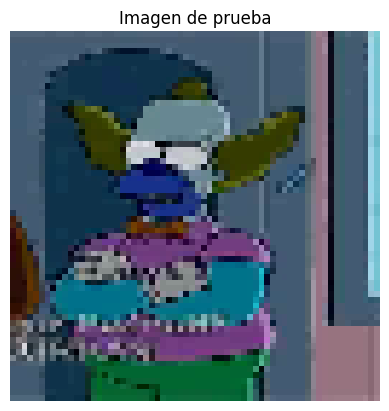

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicción: krusty_the_clown
Real:       krusty_the_clown


In [ ]:
# Escoger un índice de imagen de validación
i = 3798

# Mostrar la imagen
plt.imshow(X_val[i])
plt.title("Imagen de prueba")
plt.axis('off')
plt.show()

# Predecir
pred = modelo_final.predict(np.expand_dims(X_val[i], axis=0))
pred_clase = np.argmax(pred)
real_clase = np.argmax(y_val[i])

print(f"Predicción: {MAP_CHARACTERS[pred_clase]}")
print(f"Real:       {MAP_CHARACTERS[real_clase]}")


In [ ]:
!pip install gradio --quiet
import gradio as gr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Cargar el modelo final
modelo_gradio = load_model("mejor_modelo_aug.h5")

# Tamaño esperado por el modelo
IMG_SIZE = 64

# Función que analiza el video y devuelve texto
def predecir_video(video_path):
    cap = cv2.VideoCapture(video_path)
    resultados = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        if frame_count % 10 != 0:
            continue

        try:
            img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            img_norm = img.astype('float32') / 255.0
            pred = modelo_gradio.predict(np.expand_dims(img_norm, axis=0))[0]

            pred_idx = np.argmax(pred)
            personaje = MAP_CHARACTERS[pred_idx]
            confianza = pred[pred_idx] * 100

            resultados.append(f"Frame {frame_count}: {personaje} ({confianza:.2f}%)")
        except:
            continue

    cap.release()
    return "\n".join(resultados)

# Interfaz Gradio
interfaz = gr.Interface(
    fn=predecir_video,
    inputs=gr.Video(),
    outputs="text",
    title="Detección de Personajes de Los Simpsons",
    description="Sube un video y el modelo detectará personajes cada 10 frames usando una CNN entrenada."
)

# Lanzar interfaz
interfaz.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dfcb20cb9393fe5a6c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Detección en vivo

In [ ]:
import cv2
import numpy as np
import gradio as gr
from tensorflow.keras.models import load_model
import os # Importar el módulo os para manejar archivos

# Cargar el modelo final
try:
    modelo_gradio = load_model("mejor_modelo_aug.h5")
    print("Modelo 'mejor_modelo_aug.h5' cargado exitosamente.")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    exit() # Salir si el modelo no se puede cargar

# Tamaño de imagen esperado por el modelo
IMG_SIZE = 64

# Tu diccionario MAP_CHARACTERS
MAP_CHARACTERS = {
    0: 'homer_simpson',
    1: 'ned_flanders',
    2: 'moe_szyslak',
    3: 'lisa_simpson',
    4: 'bart_simpson',
    5: 'marge_simpson',
    6: 'krusty_the_clown',
    7: 'principal_skinner',
    8: 'charles_montgomery_burns',
    9: 'milhouse_van_houten',
    10: 'chief_wiggum',
    11: 'abraham_grampa_simpson',
    12: 'sideshow_bob',
    13: 'apu_nahasapeemapetilon',
    14: 'kent_brockman',
    15: 'comic_book_guy',
    16: 'edna_krabappel',
    17: 'nelson_muntz'
}


def predecir_video(video_path):
    print(f"Iniciando procesamiento del video: {video_path}")
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video en la ruta: {video_path}")
        return "Error: No se pudo abrir el video."

    # Obtener las propiedades del video original para el nuevo video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec para .mp4
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video detectado: {total_frames} fotogramas, {fps} FPS, {width}x{height} resolución.")

    # Crear un nombre de archivo temporal para el video de salida
    output_video_path = "temp_output_video.mp4"
    out = None # Inicializar out a None

    try:
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
        if not out.isOpened():
            print(f"Error: No se pudo crear el archivo de salida de video en la ruta: {output_video_path}")
            return "Error: No se pudo crear el archivo de salida de video."

        frame_count = 0
        # Opcional: Para acelerar, puedes procesar cada N-ésimo fotograma.
        # frame_skip = 2 # Procesar cada 2 fotogramas
        # print(f"Procesando cada {frame_skip} fotogramas para acelerar.")

        while True:
            ret, frame = cap.read()
            if not ret:
                print("Fin del video o error al leer fotograma.")
                break

            # Opcional: Activar para saltar fotogramas
            # frame_count += 1
            # if frame_count % frame_skip != 0:
            #     out.write(frame) # Asegúrate de escribir el fotograma original si lo saltas
            #     continue

            # Preprocesar el fotograma
            img = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=0)

            # Predecir
            pred_prob = modelo_gradio.predict(img)
            pred_class_idx = np.argmax(pred_prob, axis=1)[0]
            predicted_character = MAP_CHARACTERS[pred_class_idx]

            # Superponer texto en el fotograma
            cv2.putText(frame, predicted_character, (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Escribir el fotograma procesado en el nuevo archivo de video
            out.write(frame)

            if frame_count % 50 == 0: # Imprimir progreso cada 50 fotogramas
                print(f"Fotograma procesado: {frame_count}/{total_frames}")
            frame_count += 1

        print(f"Procesamiento de {frame_count} fotogramas completado.")

    except Exception as e:
        print(f"Ocurrió un error durante el procesamiento del video: {e}")
        return f"Error durante el procesamiento: {e}"
    finally:
        # Asegurarse de liberar los recursos del video
        if cap:
            cap.release()
            print("VideoCapture liberado.")
        if out:
            out.release()
            print("VideoWriter liberado.")

    print(f"Video de salida guardado en: {output_video_path}")
    return output_video_path


# Interfaz de Gradio
iface = gr.Interface(
    fn=predecir_video,
    inputs=gr.Video(label="Subir Video"),
    outputs=gr.Video(label="Video con Detección de Personajes"),
    title="Detector de Personajes de Los Simpsons",
    description="Sube un video para detectar qué personaje de Los Simpsons aparece en cada fotograma."
)

# Para lanzar la interfaz de Gradio
# Utiliza share=True si quieres un enlace público para compartir (útil en Colab)
# Utiliza debug=True para ver los mensajes de depuración en la consola
iface.launch(debug=True, share=True)

Modelo 'mejor_modelo_aug.h5' cargado exitosamente.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a972706d0195bde907.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Iniciando procesamiento del video: /tmp/gradio/e292d98bd097d86434d99e72866f8a5d8f89efab06864a8af8cfaabbc6eeaef6/The Simpsons - Barts Megaphone Testing - Simon B 360p, h264 1.mp4
Video detectado: 1524 fotogramas, 29.091 FPS, 468x360 resolución.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Fotograma procesado: 0/1524
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━

/usr/local/lib/python3.11/dist-packages/gradio/components/video.py:355: UserWarning: Video does not have browser-compatible container or codec. Converting to mp4.
  warnings.warn(


Iniciando procesamiento del video: /tmp/gradio/66a479a8d22649b87639f2e0c0c17e683464adf2c81a133e7da5845a8b45fc30/Homer Simpson Swearing - ez1337ze 360p, h264.mp4
Video detectado: 822 fotogramas, 30.0 FPS, 480x360 resolución.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Fotograma procesado: 0/822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/gradio/components/video.py:355: UserWarning: Video does not have browser-compatible container or codec. Converting to mp4.
  warnings.warn(
